In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize,TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim

# Ensure NLTK resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Step 1: Load the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
#DATASET_ENCODING = "latin-1"
df = pd.read_csv("training.1600000.processed.noemoticon.csv",
                 encoding=DATASET_ENCODING,
                 names=DATASET_COLUMNS,
                 on_bad_lines='skip')
print("Unique value counts in the target column:")
print(df['target'].value_counts())
df

Unique value counts in the target column:
target
0    800000
4    800000
Name: count, dtype: int64


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
stopwordlist = set(stopwords.words('english'))

# Add context-specific stopwords if necessary
custom_stopwords = {
    'user', 'users', 'said', 'says', 'say', 'like', 'get', 'got',
    'go', 'going', 'know', 'just', 'really'
}
stopwordlist.update(custom_stopwords)


In [4]:
def clean_text(text):
    # Function to get NLTK POS tag to WordNet POS tag
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    # Replace @mentions with 'USER'
    text = re.sub(r'@[\S]+', 'USER', text)
    # Remove hashtags but keep the text
    text = re.sub(r'#(\S+)', r'\1', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespace
    text = text.strip()

    # Tokenize text using TweetTokenizer
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)

    # Remove stopwords and lemmatize tokens with POS tagging
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []

    pos_tags = nltk.pos_tag(tokens)

    for token, tag in pos_tags:
        if token not in stopwordlist:
            lemmatized_token = lemmatizer.lemmatize(token, get_wordnet_pos(tag))
            lemmatized_tokens.append(lemmatized_token)

    return " ".join(lemmatized_tokens)

In [5]:
# Define the desired sample size for each class
sample_size = 500000  # Adjust this as needed

# Perform stratified sampling
sample_df = df.groupby('target', group_keys=False).apply(lambda x: x.sample(n=sample_size, random_state=42))

# Check the shape and distribution of the downsampled data
print(sample_df.shape)
print(sample_df['target'].value_counts())

"""sample_df=pd.read_csv('CleanSample_df.csv')"""

(1000000, 6)
target
0    500000
4    500000
Name: count, dtype: int64


<ipython-input-5-dd179e37b2d4>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('target', group_keys=False).apply(lambda x: x.sample(n=sample_size, random_state=42))


"sample_df=pd.read_csv('CleanSample_df.csv')"

In [6]:
# sample_df = df.copy()
sample_df

,target,ids,date,flag,user,text
212188,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...
299036,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...
475978,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I..."
588988,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food
138859,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...
...,...,...,...,...,...,...
1217827,4,1989775916,Mon Jun 01 02:46:09 PDT 2009,NO_QUERY,j4ngis,@GrahamHill Those *are* excellent benefits
1586827,4,2190858894,Tue Jun 16 03:55:19 PDT 2009,NO_QUERY,Rorschach7,@TeevieAlan Thanks man!
1555034,4,2185032121,Mon Jun 15 16:46:58 PDT 2009,NO_QUERY,tweeteradder4,@yukinokotori Get 100 followers a day using ww...
1140846,4,1977094369,Sat May 30 20:05:15 PDT 2009,NO_QUERY,clairececil,hi nichkhun i like you!


In [7]:
sample_df["text"].iloc[5]

'@xPowxBangxBoomx dammiitt!! i wish i had MTV '

In [8]:
clean_text(sample_df["text"].iloc[5])

'USER dammiitt ! ! wish mtv'

In [9]:
# Replace target values
sample_df['target'] = sample_df['target'].replace(4, 1)

In [10]:
# Preprocess the text data
sample_df['text'] = sample_df['text'].apply(clean_text)


In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sample_df['text'], sample_df['target'], test_size=0.2, random_state=42)

X_train[:10], X_test[:10], y_train[:10], y_test[:10]

(1575013    anyone want supernatural episode ? ? ? yeah gi...
 282567                                         summer wake :
 440405               dissappointed find perez hilton cuban .
 1471158                                   storm brewing head
 1514561                        USER hi celia - thanks follow
 300450                     starbucks study . hate final week
 366086               USER fun mutha fuckin boat ! i'll sho .
 948090     proom hit . ! tht impressd bt nd date w badddd...
 1195806    USER want girl amaze summer ball last night , ...
 1420936     phone josh talkin subject .. =p talk jobless ...
 Name: text, dtype: object,
 1420737                               im lose twitter v-card
 508625                         hour sleep ... thank ! office
 1071130    gonna write question , ill make answer video t...
 1472872    amazing time yeserday except rash legs stomach...
 504406                            USER hot tub . missin girl
 318119                            USER wh

In [12]:
sample_df.target.value_counts()

,count
target,
0,500000
1,500000


In [13]:
sample_df['target'] = sample_df['target'].replace(4, 1)
sample_df.target.value_counts()

,count
target,
0,500000
1,500000


In [14]:
sample_df.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


In [15]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800000,), (200000,), (800000,), (200000,))

# Vectorization

In [16]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

# Fit and transform the training data
X_train_vect = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_vect = vectorizer.transform(X_test)


In [17]:
X_train_vect.shape, X_test_vect.shape

((800000, 500000), (200000, 500000))

In [18]:
n_components = 50  # You can adjust this value based on your needs
svd = TruncatedSVD(n_components=n_components)
X_train_reduced = svd.fit_transform(X_train_vect)
X_test_reduced = svd.transform(X_test_vect)


In [19]:
X_train_reduced.shape,X_test_reduced.shape

((800000, 50), (200000, 50))

In [20]:
# Step 3: Build the Neural Network model in PyTorch
class SentimentModel(nn.Module):
    def __init__(self, input_dim):
        super(SentimentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)   #y = mx+b , regression +sigmoid = classification
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc4 = nn.Linear(128, 64) #y = mx+b
        self.dropout =nn.Dropout(0.2)
        self.fc5 = nn.Linear(64, 32) #y = mx+b
        self.dropout =nn.Dropout(0.2)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

# Instantiate the model and set device for GPU usage
input_dim = X_train_reduced.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if GPU is available
model = SentimentModel(input_dim).to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = nn.BCELoss() # log loss mse  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.012)

In [21]:
# Convert training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_reduced, dtype=torch.float32).to(device)  # Move to device
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)  # Reshape and move to device

X_test_tensor = torch.tensor(X_test_reduced, dtype=torch.float32).to(device)  # Move to device
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

In [22]:
y_train.value_counts()

,count
target,
0,400013
1,399987


In [23]:
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

num_epochs = 500
batch_size = 25000

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        # Get mini-batch inputs and targets
        X_batch = X_train_tensor[i:i + batch_size].to(device)  # Move input batch to device
        y_batch = y_train_tensor[i:i + batch_size].to(device)  # Move target batch to device

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 250 == 0:
      print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/500], Loss: 0.6135
Epoch [250/500], Loss: 0.5133


In [24]:
"""num_epochs = 5
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        # Get mini-batch inputs and targets
        X_batch = X_train_tensor[i:i + batch_size]
        y_batch = y_train_tensor[i:i + batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')"""

"num_epochs = 5\nbatch_size = 64\n\nfor epoch in range(num_epochs):\n    model.train()\n    for i in range(0, len(X_train_tensor), batch_size):\n        # Get mini-batch inputs and targets\n        X_batch = X_train_tensor[i:i + batch_size]\n        y_batch = y_train_tensor[i:i + batch_size]\n\n        # Forward pass\n        outputs = model(X_batch)\n        loss = criterion(outputs, y_batch)\n\n        # Backward pass and optimization\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')"

In [25]:
import pickle

# Save the model to disk
torch.save(model.state_dict(), 'sentiment_model.pth')

# Save the vectorizer and SVD to disk using pickle
with open('vectorizer_s1.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('sentiment_model_s1.pkl', 'wb') as f:
    pickle.dump(svd, f)

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


<ipython-input-26-fe19cae179f4>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sentiment_model.pth'))


              precision    recall  f1-score   support

           0       0.73      0.76      0.74     99987
           1       0.75      0.71      0.73    100013

    accuracy                           0.73    200000
   macro avg       0.74      0.73      0.73    200000
weighted avg       0.74      0.73      0.73    200000



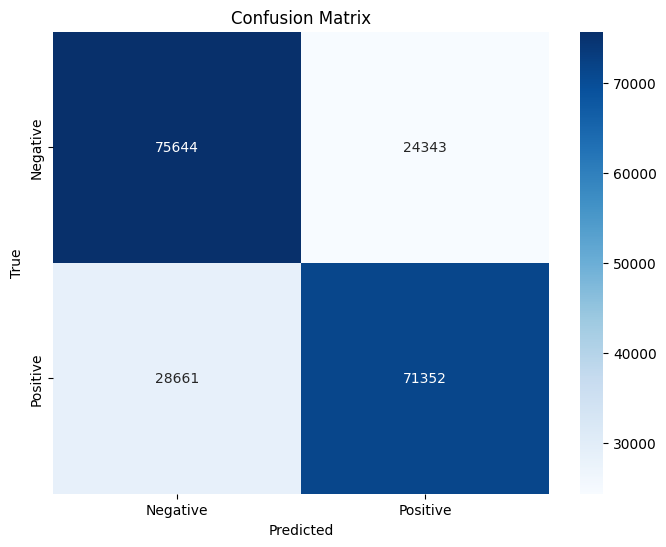

In [26]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
input_dim = X_train_reduced.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentModel(input_dim).to(device)
model.load_state_dict(torch.load('sentiment_model.pth'))
model.eval()

# Move test tensor to the correct device
X_test_tensor = X_test_tensor.to(device)

# Make predictions on the test set
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()

# Convert predictions and true labels to NumPy arrays
y_pred = y_pred.cpu().numpy().flatten()  # Move predictions back to CPU for further processing
y_test = y_test # Assuming y_test is already a NumPy array or can be converted

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


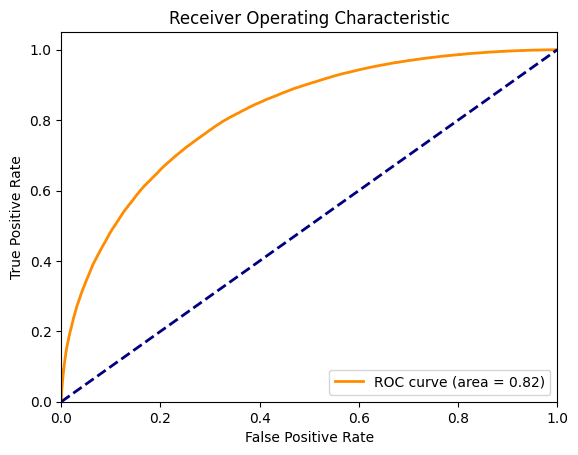

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_pred_probs contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs.cpu().numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score

# Assuming y_test and y_pred are already defined from your previous code

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)


print(f"accuracy: {accuracy}")
print(f"Precision: {precision}")

accuracy: 0.73498
Precision: 0.7456188933591097
